In [1]:
# !pip install torch torchvision -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import List, Dict
import random
from tqdm import tqdm
import torch

# from google.colab import drive
# drive.mount('/content/drive/')
# sys.path.append("/content/drive/My Drive/code/QMUL/research_project/initial_idea_exploration")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# random seeding
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Matplotlib is building the font cache; this may take a moment.


Using device: cpu


In [ ]:
class GaussianDataGenerator:
    """
    A class for generating random toy data with Gaussian distributions and controlled perturbations.

    This class:
    - generates data with a specified number of features
    - controls wheter features are discrete or continuous
    - adds controlled perturbations to the data
    - visualises the generated data
    """

    def __init__(self, n_samples: int=1000, n_features: int=10, random_state: int=SEED):
      """
      Initialise the GaussianDataGenerator.

      Parameters:
      -----------
      n_samples (int): Number of samples to generate.
      n_features (int): Number of features in each sample.
      random_state (int): Seed for the random number generator.
      """
      self.n_samples = n_samples
      self.n_features = n_features
      self.random_state = random_state
      self.data = None
      self.feature_types = {}
      self.feature_parameters = {}
      np.random.seed(self.random_state)

    def generate_features(self,
                          feature_parameters: Dict[str, Dict] = None,
                          feature_types: Dict[str, str] = None):
      """
      Generate features based on specified parameters.

      Parameters:
      -----------
      feature_parameters (Dict[str, Dict]): Dictionary mapping feature names to their distribution parameters.
      Example: {'feature1': {'mean': 0, 'std': 1}, 'feature2': {'mean': 5, 'std': 2}}
      feature_types (Dict[str, str]): Dictionary mapping feature names to their types ('continuous' or 'discrete')
      Example: {'feature1': 'continuous', 'feature2': 'discrete'}

      Returns:
      --------
      self : GaussianDataGenerator
      Returns self for method chaining
      """
      # no parmaeters provided, generate default
      if feature_parameters is None:
        feature_parameters = {}
        for i in range(self.n_features):
          feature_name = f"feature_{i}"
          feature_parameters[feature_name] = {'mean': np.random.uniform(-5, 5),
                                              'std': np.random.uniform(0.5, 3)}

      # no types provided, generate all continuous
      if feature_types is None:
        feature_types = {}
        for feature_name in feature_parameters.keys():
          feature_types[feature_name] = 'continuous'

      self.feature_parameters = feature_parameters
      self.feature_types = feature_types

      # generate data
      data_dictionary = {}
      for feature_name, parameters in feature_parameters.items():
        # continuous data
        raw_data = np.random.normal(parameters['mean'], parameters['std'], self.n_samples)

        # if specified, convert to discrete
        if feature_types.get(feature_name) == 'discrete':
          raw_data = np.round(raw_data)

        data_dictionary[feature_name] = raw_data

      self.data = pd.DataFrame(data_dictionary)

      print("Feature parameters:", feature_parameters)
      print("Data dictionary keys:", data_dictionary.keys())
      print("Data dictionary first values:", {k: v[:5] for k, v in data_dictionary.items()})
      self.data = pd.DataFrame(data_dictionary)
      print("DataFrame shape:", self.data.shape)
      print("DataFrame columns:", self.data.columns)

      return self

    def add_perturbations(self,
                          perturbation_type: str = 'gaussian',
                          features: List[str] = None,
                          scale: float = 0.1):
      """
      Add controlled perturbations to the data.

      Parameters:
      -----------
      perturbation_type (str): Type of perturbation ('gaussian', 'uniform'')
      features (List[str]): List of features to perturb. If None, perturb all features.
      scale (float): Scale of the perturbation.

      Returns:
      --------
      self : GaussianDataGenerator
      Returns self for method chaining
      """
      if self.data is None:
        raise ValueError("No data generated. Call generate_features() first.")

      if features is None:
        features = self.data.columns.tolist()

      perturbed_data = self.data.copy()

      for feature in features:
        if feature not in self.data.columns:
            continue

        if perturbation_type == 'gaussian':
          # gaussian noise
          noise = np.random.normal(0, scale * self.data[feature].stdd(), self.n_samples)
          perturbed_data[feature] += noise

        elif perturbation_type == 'uniform':
          # uniform noise
          noise = np.random.uniform(-scale, scale, self.n_samples) * self.data[feature].std()
          perturbed_data[feature] += noise

        # ensure discrete features remain discrete
        if self.feature_types.get(feature) == 'discrete':
          perturbed_data[feature] = np.round(perturbed_data[feature])

      self.data = perturbed_data
      return self

    def add_features(self,
                     n_new_features: int=1,
                     feature_parameters: Dict[str, Dict] = None,
                     feature_types: Dict[str, str] = None):
      """
      Add new features to the existing dataset.

      Parameters:
      -----------
      n_new_features (int): Number of new features to add.
      feature_parameters (Dict[str, Dict]): Parameters for the new features
      feature_types (Dict[str, str]): Types for the new features

      Returns:
      --------
      self : GaussianDataGenerator
      Returns self for method chaining
      """
      # if no data exists, increase n_features and generate data
      if self.data is None:
        self.n_features += n_new_features
        return self.generate_features(feature_parameters, feature_types)

      # generate default parameters if none provided
      if feature_parameters is None:
        feature_parameters = {}
        start_idx = len(self.data.columns)
        for i in range(n_new_features):
          feature_name = f"feature_{start_idx + i}"
          feature_parameters[feature_name] = {'mean': np.random.uniform(-5, 5),
                                              'std': np.random.uniform(0.5, 3)}

      # generate default types if none provided
      if feature_types is None:
        feature_types = {}
        for feature_name in feature_parameters.keys():
          feature_types[feature_name] = 'continuous'

      # generate new features
      new_data = {}
      for feature_name, parameters in feature_parameters.items():
        # continuous
        raw_data = np.random.normal(parameters['mean'], parameters['std'], self.n_samples)

        # if specified, convert to discrete
        if feature_types.get(feature_name) == 'discrete':
          raw_data = np.round(raw_data)

          new_data[feature_name] = raw_data

          # update parameters and types
          self.feature_parameters[feature_name] = parameters
          self.feature_types[feature_name] = feature_types.get(feature_name, 'continuous')

      # add new features to existing data
      self.data = pd.concat([self.data, pd. DataFrame(new_data)], axis=1)
      self.n_features = len(self.data.columns)

      return self

    def change_feature_type(self, feature_name: str, new_type: str):
      """
      Change the type of a feature (continuous or discrete).

      Parameters:
      -----------
      feature_name (str): Name of the feature to change
      new_type (str): New type, 'continuous' or 'discrete'

      Returns:
      --------
      self : GaussianDataGenerator
          Returns self for method chaining
      """
      if self.data is None or feature_name not in self.data.columns:
        raise ValueError(f"Feature {feature_name} not found in the data.")

      if new_type not in ['continuous', 'discrete']:
        raise ValueError("Invalid feature type. Use 'continuous' or 'discrete'.")

      self.feature_types[feature_name] = new_type

      # apply type change
      if new_type == 'discrete':
        self.data[feature_name] = np.round(self.data[feature_name])
      else: # new_type == 'continuous':
            # no transformation needed
          pass
      return self

    def visusalise_features(self, features: List[str] = None, n_bins: int = 30):
      """
      Visualise the distribution of selected features.

      Parameters:
      -----------
      features (List[str]): List of features to visualise. If None, visualise all features.
      n_bins (int): Number of bins for histogram.

      Returns:
      --------
      None
      """
      if self.data is None:
        raise ValueError("No data generated. Call generate_features() first.")

      if features is None:
        features = self.data.columns.tolist()

      if not features:
        print("No features to visualise.")
        return

      n_features = len(features)
      n_cols = min(3, n_features)
      n_rows = (n_features + n_cols - 1) // n_cols

      # visualise first 10 features
      if len(features) > 10:
        print(f"Too many features to visualise. Showing first 10 out of {len(features)}.")
        features = features[:10]

      n_features = len(features)
      n_cols = min(3, n_features)
      n_rows = (n_features + n_cols - 1) // n_cols

      fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
      if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
      axes = axes.flatten()

      for i, feature in enumerate(features):
        if i < len(axes):
          ax = axes[i]
          self.data[feature].hist(bins=n_bins,
                                  ax=ax, alpha=0.7)
          ax.set_title(f"{feature} ({self.feature_types.get(feature, 'unknown')})")
          ax.axvline(self.data[feature].mean(),
                     color='red',
                     linestyle='--',
                     label=f"Mean: {self.data[feature].mean():.2f}")
          ax.axvline(self.data[feature].median(),
                     color='green',
                     linestyle='-',
                     label=f"Median: {self.data[feature].median():.2f}")
          ax.legend()

      # hide unused plots
      for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

      plt.tight_layout()
      plt.show()

    def get_data(self):
      """
      Get the generated data.

      Returns:
      --------
      (pd.DataFrame): The generated data.
      """
      if self.data is None:
        raise ValueError("No data generated. Call generate_features() first.")

      return self.data

    def get_feature_information(self):
      """
      Get information about the features.

      Returns:
      --------
      (dict): Dictionary containing feature parameters and types
      """
      return {
            'feature_parameters': self.feature_parameters,
            'feature_types': self.feature_types
        }

    def create_target_variable(self,
                               features_to_use: List[str] = None,
                               weights: List[float] = None,
                               noise_level: float = 0.1,
                               function_type: str = 'linear'):
      """
      Create a target variable based on the selected features.

      Parameters:
      -----------
      features_to_use (List[str]): List of features to use for creating the target. If None, use all features.
      weights (List[float]): Weights for each feature. If None, generate random weights.
      noise_level (float): Level of noise to add to the target
      function_type (str): Type of function to use ('linear', 'polynomial', 'logistic')

      Returns:
      --------
      self : GaussianDataGenerator
      Returns self for method chaining
      """
      if self.data is None:
        raise ValueError("No data generated. Call generate_features() first.")

      if features_to_use is None:
        features_to_use = self.data.columns.tolist()

      if weights is None:
        weights = np.random.uniform(-1, 1, len(features_to_use))

      if len(weights) != len(features_to_use):
        raise ValueError("Number of weights must match number of features.")

      # extract the features to use
      X = self.data[features_to_use].values

      # standardise features
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(X)

      # create target variable based on function type
      if function_type == 'linear':
        y = np.dot(X_scaled, weights)

      elif function_type == 'polynomial':
        y = np.dot(X_scaled, weights) + np.sum(0.5 * weights * X_scaled**2, axis=1)

      elif function_type == 'logistic':
        # create binary target using a logistic function
        logits = np.dot(X_scaled, weights)
        y = 1 / (1 + np.exp(-logits))
        # convert to binary
        y = (y > 0.5).astype(int)

      else:
        raise ValueError("Invalid function type. Use 'linear', 'polynomial', or 'logistic'.")

      # add noise (except for logistic. already binary)
      if function_type != 'logistic':
        noise = np.random.normal(0, noise_level, self.n_samples)
        y += noise

      # add target to the data
      self.data['target'] = y
      return self


Feature parameters: {'feature_0': {'mean': -1.254598811526375, 'std': 2.87678576602479}, 'feature_1': {'mean': 2.3199394181140507, 'std': 1.9966462104925915}, 'feature_2': {'mean': -3.439813595575635, 'std': 0.8899863008405067}, 'feature_3': {'mean': -4.419163878318005, 'std': 2.665440364437338}, 'feature_4': {'mean': 1.0111501174320878, 'std': 2.2701814444901136}, 'feature_5': {'mean': -4.7941550570419755, 'std': 2.9247746304049858}, 'feature_6': {'mean': 3.324426408004218, 'std': 1.0308477766956905}, 'feature_7': {'mean': -3.181750327928994, 'std': 0.9585112746335845}, 'feature_8': {'mean': -1.9575775704046228, 'std': 1.8118910790805947}, 'feature_9': {'mean': -0.6805498135788426, 'std': 1.2280728504951048}, 'feature_10': {'mean': 1.118528947223795, 'std': 0.8487346516301046}, 'feature_11': {'mean': -2.0785535146478185, 'std': 1.4159046082342293}}
Data dictionary keys: dict_keys(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', '

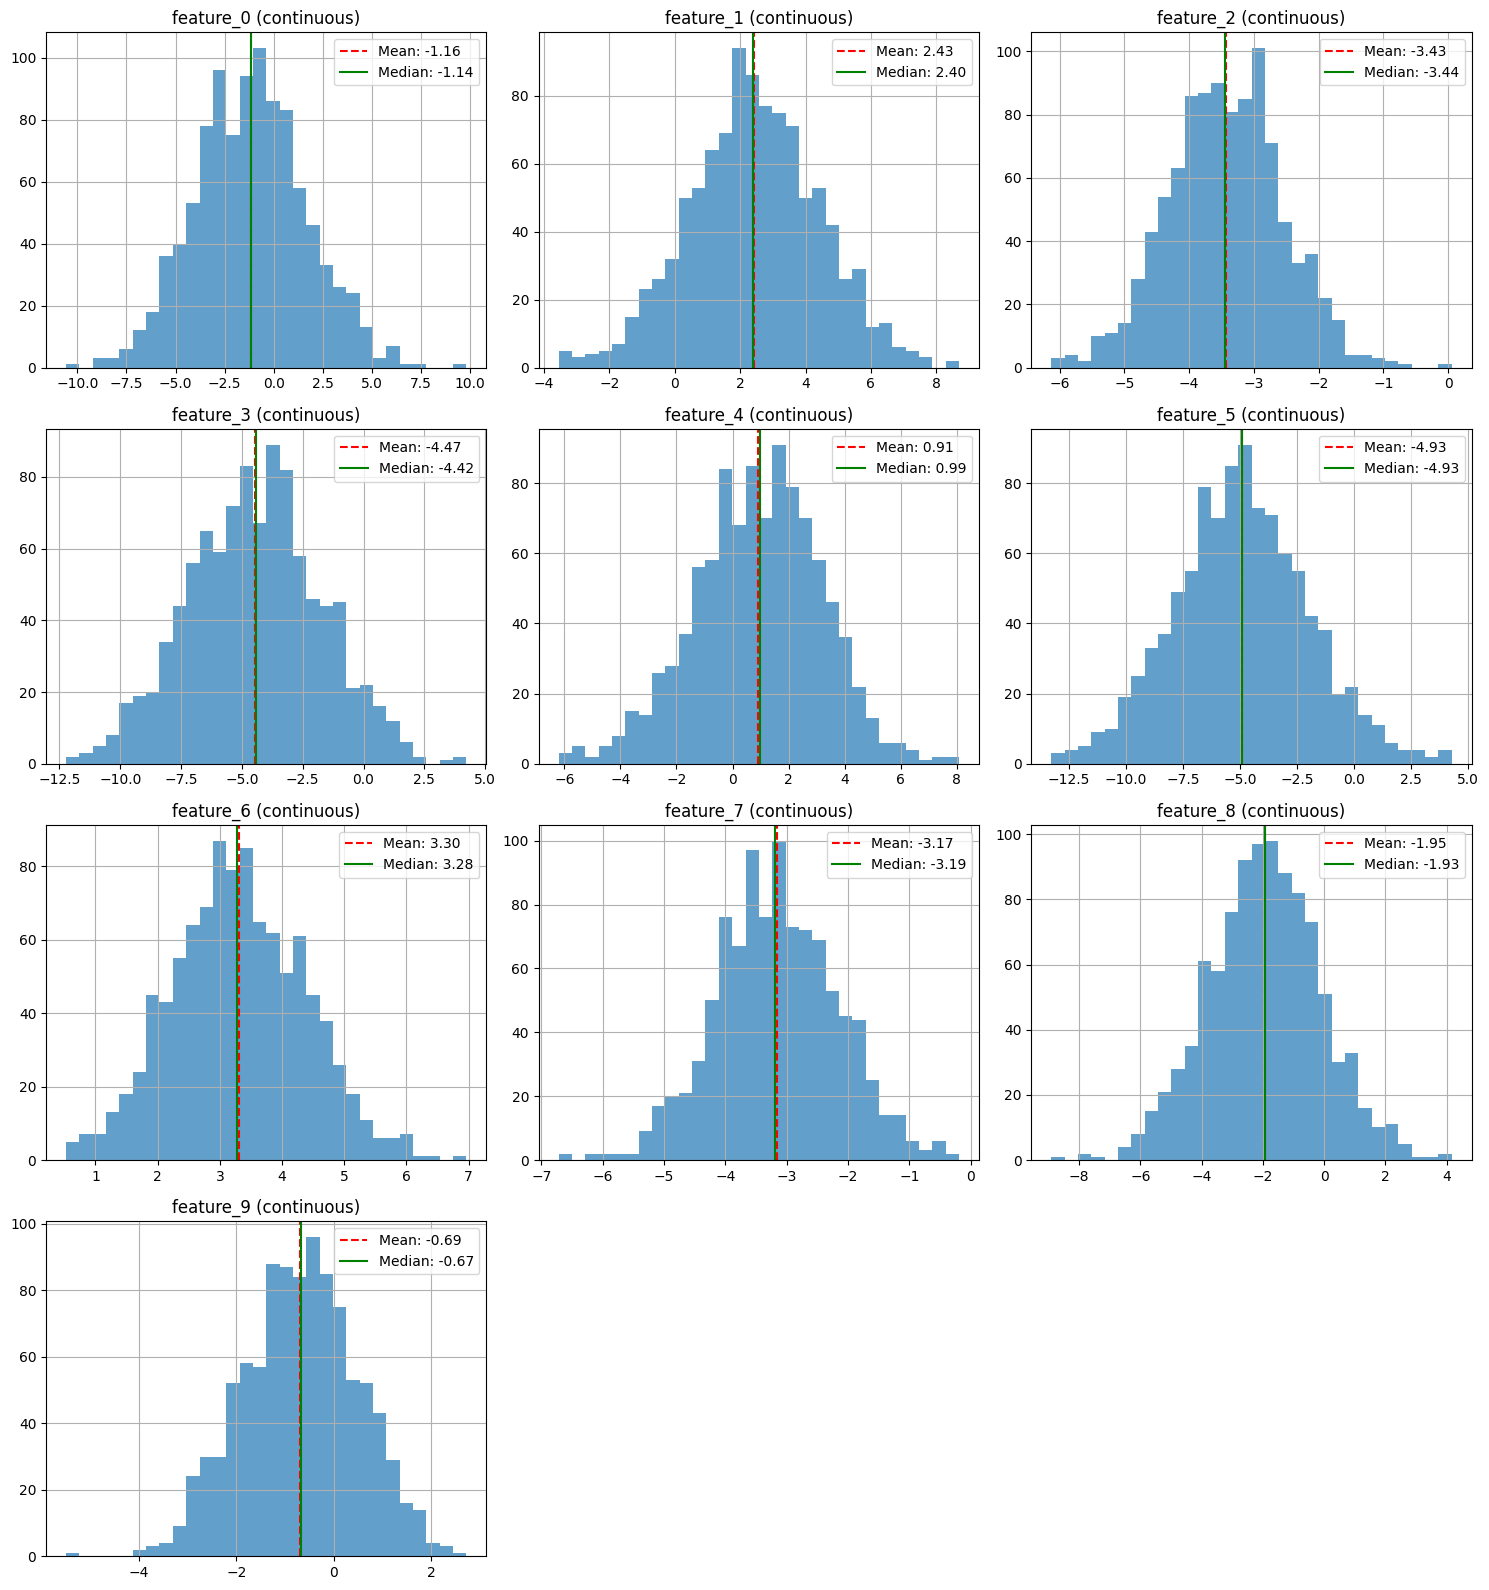

In [ ]:
# generator with default parameters
default_generator = GaussianDataGenerator(n_samples=1000, n_features=12)
default_generator.generate_features()

print("Default generator:")
print(default_generator.get_data().head)
default_generator.visusalise_features()